In [17]:
import datetime
import os
import time
from pathlib import Path
from typing import Dict, List, Optional, Union

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
from torchvision import utils as vutils

from dataset import EMnistDataset

gen_img_root = Path("gan_wgan/images")
weights_root = Path("gan_wgan/weights")
loss_root = Path("gan_wgan/loss")
gen_img_root.mkdir(exist_ok=True)
weights_root.mkdir(exist_ok=True)
loss_root.mkdir(exist_ok=True)
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

In [4]:
class Parse:
    def __init__(self) -> None:
        self.n_epochs = 200
        self.batch_size = 64
        self.lr = 0.0002
        self.b1 = 0.5
        self.b2 = 0.999
        self.n_cpu = 8
        self.latent_dim = 100
        self.img_size = 32
        self.channels = 1
        self.sample_interval = 10000


opt = Parse()

# %%
torch.manual_seed(42)
torch.backends.cudnn.deterministic = True

torch.cuda.set_device(2)
device = torch.device("cuda:2" if torch.cuda.is_available() else "cpu")
print("device", torch.cuda.current_device(), torch.cuda.get_device_name(torch.cuda.current_device()))

device 2 NVIDIA GeForce RTX 2080 Ti


In [5]:
def weights_init_normal(m):
    classname = m.__class__.__name__
    if classname.find("Conv") != -1:
        torch.nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find("BatchNorm2d") != -1:
        torch.nn.init.normal_(m.weight.data, 1.0, 0.02)
        torch.nn.init.constant_(m.bias.data, 0.0)
        
def show_images(real_imgs, fake_imgs: None, nrow=6, ncol=6, figsize=(10, 10), save: bool = False, show: bool = True, name=""):
    # compare and show n*m images from generator in one figure and optionally save it
    for imgs, label in zip([imgs for imgs in [real_imgs, fake_imgs] if fake_imgs is not None], ["real", "fake"]):
        imgs = imgs[:nrow * ncol]
        imgs = imgs.view(imgs.size(0), opt.channels, opt.img_size, opt.img_size)
        plt.figure(figsize=figsize)
        plt.imshow(np.transpose(vutils.make_grid(imgs, nrow=nrow, padding=2, normalize=True).cpu(), (1, 2, 0)))
        plt.axis('off')
        plt.title(name + label + " images")
        if save:
            plt.savefig(gen_img_root / (name + label + " images.png"))
        if show:
            plt.show()

def to_td(second: Union[int, float]) -> str:
    # convert seconds to time delta
    return str(datetime.timedelta(seconds=int(second)))

In [6]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()

        def block(in_feat, out_feat, normalize=True):
            layers = [nn.Linear(in_feat, out_feat)]
            if normalize:
                layers.append(nn.BatchNorm1d(out_feat, 0.8))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            return layers

        self.model = nn.Sequential(
            *block(opt.latent_dim, 128, normalize=False),
            *block(128, 256),
            *block(256, 512),
            *block(512, 1024),
            nn.Linear(1024, int(np.prod(img_shape))),
            nn.Tanh()
        )

    def forward(self, z):
        img = self.model(z)
        img = img.view(img.shape[0], *img_shape)
        return img

In [7]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()

        def discriminator_block(in_filters, out_filters, bn=True):
            block = [nn.Conv2d(in_filters, out_filters, 3, 2, 1), nn.LeakyReLU(0.2, inplace=True), nn.Dropout2d(0.25)]
            if bn:
                block.append(nn.BatchNorm2d(out_filters, 0.8))
            return block

        self.model = nn.Sequential(
            *discriminator_block(opt.channels, 16, bn=False),
            *discriminator_block(16, 32),
            *discriminator_block(32, 64),
            *discriminator_block(64, 128),
        )

        # The height and width of downsampled image
        ds_size = opt.img_size // 2**4
        self.adv_layer = nn.Sequential(nn.Linear(128 * ds_size**2, 1), nn.Sigmoid())

    def forward(self, img):
        out = self.model(img)
        out = out.view(out.shape[0], -1)
        validity = self.adv_layer(out)

        return validity

In [13]:
# %%
# Loss function
adversarial_loss = nn.BCELoss()

# Initialize generator and discriminator
img_shape = (1, 32, 32)
generator = Generator()
discriminator = Discriminator()

generator.to(device)
discriminator.to(device)

# Initialize weights
generator.apply(weights_init_normal)
discriminator.apply(weights_init_normal)

# Configure data loader
dataloader = DataLoader(
    EMnistDataset(root_dir="./EMNIST/ndy/emnist-byclass-train-images.npy",
                  transform=transforms.Compose([transforms.ToTensor(),
                                                transforms.Resize((32,32)),
                                                transforms.Normalize([0.5], [0.5])])),
    batch_size=opt.batch_size,
    shuffle=True,
)

# Optimizers
optimizer_G = torch.optim.Adam(generator.parameters(), lr=opt.lr, betas=(opt.b1, opt.b2))
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=opt.lr, betas=(opt.b1, opt.b2))

# record trianing loss
record: Dict[str, List[float]] = {"D_loss": [], "G_loss": []}

In [14]:
def train():
    training_start = time.time()
    for epoch in range(opt.n_epochs):
        loss_d_e = 0
        loss_g_e = 0
        for i, imgs in enumerate(dataloader):

            # Configure input
            real_imgs = imgs.to(device)
            # -----------------
            #  Train Generator
            # -----------------

            optimizer_G.zero_grad()

            # Sample noise as generator input
            z = torch.randn(imgs.size(0), opt.latent_dim).to(device)

            # Generate a batch of images
            fake_imgs = generator(z)

            # Loss measures generator's ability to fool the discriminator
            fake_pred = discriminator(fake_imgs)
            g_loss = adversarial_loss(fake_pred, torch.ones_like(fake_pred))

            g_loss.backward()
            optimizer_G.step()

            # ---------------------
            #  Train Discriminator
            # ---------------------

            optimizer_D.zero_grad()

            # Measure discriminator's ability to classify real from generated samples
            real_pred = discriminator(real_imgs)
            fake_pred = discriminator(fake_imgs.detach())
            real_loss = adversarial_loss(real_pred, torch.ones_like(real_pred))
            fake_loss = adversarial_loss(fake_pred, torch.zeros_like(fake_pred))
            d_loss = (real_loss + fake_loss) / 2

            d_loss.backward()
            optimizer_D.step()

            loss_d_e += d_loss.item()
            loss_g_e += g_loss.item()
            batches_done = epoch * len(dataloader) + i

            if batches_done % (opt.sample_interval // 100 + 1) == 0:
                diff = time.time() - training_start
                a_td = to_td(diff)
                al_td = to_td(diff * opt.n_epochs * len(dataloader) / (epoch * len(dataloader) + i + 1))
                per_df = diff / (epoch + 1 + i / len(dataloader))

                print(f"\r E{epoch+1:03}B{i+1:03}, [{a_td}/{al_td}] {per_df:5.2f}s/epoch",
                      f"D_loss: {d_loss.item():6.4f} = r{real_loss.item():6.4f} + f{fake_loss.item():6.4f}",
                      f" G_loss: {g_loss.item():6.4f}",
                      end="")

            if batches_done % opt.sample_interval == 0:
                show_images(real_imgs, fake_imgs, save=True, name=f"E{epoch+1:03}B{i+1:03} ")
                if batches_done > 10:
                    torch.save(generator.state_dict(), weights_root / f"E{epoch+1:03}B{i+1:03}G.pth")
                    torch.save(discriminator.state_dict(), weights_root / f"E{epoch+1:03}B{i+1:03}D.pth")

        record["D_loss"].append(loss_d_e / len(dataloader))
        record["G_loss"].append(loss_g_e / len(dataloader))

 E001B001, [0:00:00/8 days, 10:39:25]  0.33s/epoch D_loss: 0.6932 = r0.6851 + f0.7013  G_loss: 0.6851

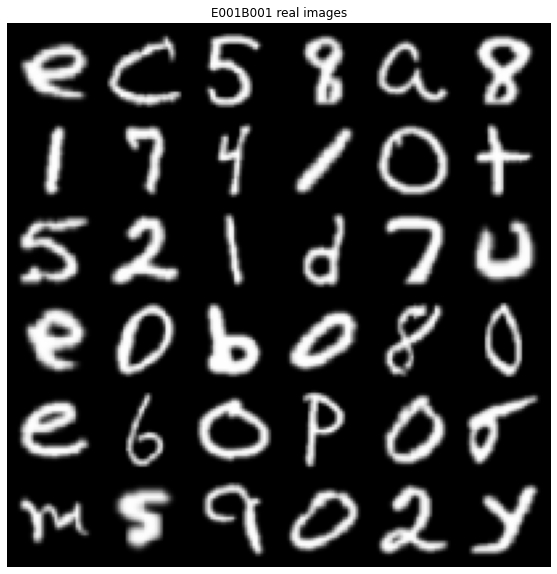

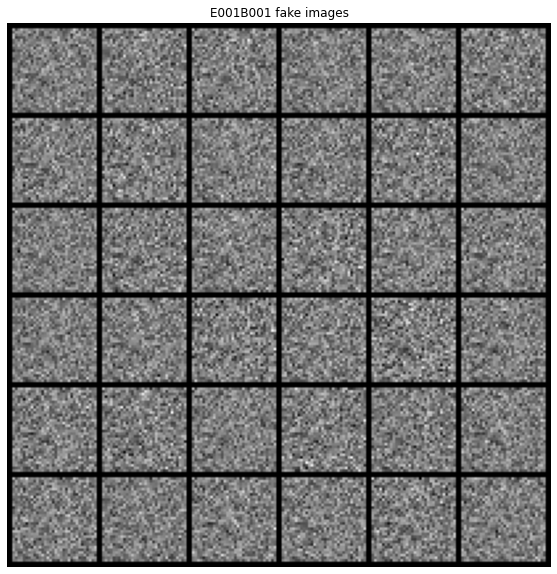

save interrupt
save final


In [15]:
try:
    train()
except KeyboardInterrupt:
    torch.save(generator.state_dict(), weights_root / f"interruptG.pth")
    torch.save(discriminator.state_dict(), weights_root / f"interruptD.pth")
    Dloss = np.array(record["D_loss"])
    Gloss = np.array(record["G_loss"])
    np.save(loss_root / "Dloss", Dloss)
    np.save(loss_root / "Gloss", Gloss)
    print("save interrupt")
    
torch.save(generator.state_dict(), weights_root / f"finalG.pth")
torch.save(discriminator.state_dict(), weights_root / f"finalD.pth")
np.save(loss_root / "Dloss", Dloss)
np.save(loss_root / "Gloss", Gloss)
print("save final")

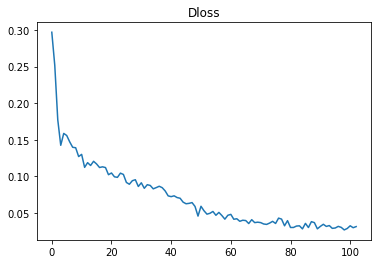

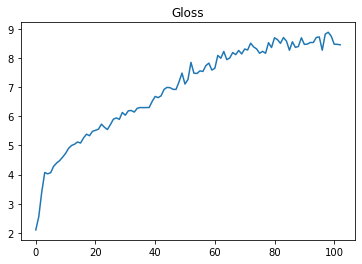

In [18]:
def print_loss(path, title):
    loss = np.load(path)
    plt.plot(loss)
    plt.title(title)
    plt.show()
    
print_loss("gan_wgan/loss/Dloss.npy", "Dloss")
print_loss("gan_wgan/loss/Gloss.npy", "Gloss")